<a href="https://colab.research.google.com/github/meetali-sharma/MarketSegmentation/blob/main/McDonald's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.metrics import log_loss, adjusted_rand_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import seaborn as sns



mcdonalds = pd.read_csv('mcdonalds.csv')  # Load the dataset

In [3]:
# Inspecting basic features such as variable names, size and first 3 rows of the data

Variable_names = mcdonalds.columns
print(Variable_names)

print(mcdonalds.head(3))

mcdonalds.shape  # give size of the dataset(row, column)

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


(1453, 15)

In [4]:
#taking first 11 columns from the data set because these columns contain the segmentation variables

mcdonalds_binary = (mcdonalds.iloc[:, 0:11] == "Yes").astype(int) # Identify all yes entries and converting them to 1

mcdonalds_binary.mean().round(2)  # Check the data transformed correctly by taking average of each transformed segmentation variable

,0
yummy,0.55
convenient,0.91
spicy,0.09
fattening,0.87
greasy,0.53
fast,0.90
cheap,0.60
tasty,0.64
expensive,0.36
healthy,0.20


In [5]:

# Apply PCA
pca = PCA()
MD_pca = pca.fit(mcdonalds_binary)

# Standard deviations (square root of explained variance)
std_dev = np.round(np.sqrt(pca.explained_variance_), 1)   # It helps decide how many components to keep.
print("Standard deviations:")
print(std_dev)

# Explained variance ratio
explained_var_ratio = np.round(pca.explained_variance_ratio_, 2)  #Tells how much variance each component captures.
cumulative_var = np.round(np.cumsum(explained_var_ratio), 2)

summary_df = pd.DataFrame({
    'Explained Variance': explained_var_ratio,
    'Cumulative Variance': cumulative_var
})
print("\nSummary:")
print(summary_df)

# Rotation matrix (components_), tells how much each original variable contributes to each PC

rotation = pd.DataFrame(np.round(pca.components_.T, 2),
                        index=mcdonalds_binary.columns,
                        columns=[f'PC{i+1}' for i in range(len(mcdonalds_binary.columns))])
print("\nRotation matrix:")
print(rotation)


Standard deviations:
[0.8 0.6 0.5 0.4 0.3 0.3 0.3 0.3 0.3 0.2 0.2]

Summary:
    Explained Variance  Cumulative Variance
0                 0.30                 0.30
1                 0.19                 0.49
2                 0.13                 0.62
3                 0.08                 0.70
4                 0.06                 0.76
5                 0.05                 0.81
6                 0.04                 0.85
7                 0.04                 0.89
8                 0.04                 0.93
9                 0.03                 0.96
10                0.03                 0.99

Rotation matrix:
             PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10  PC11
yummy       0.48 -0.36  0.30  0.06  0.31 -0.17 -0.28 -0.01 -0.57  0.11 -0.05
convenient  0.16 -0.02  0.06 -0.14 -0.28  0.35 -0.06  0.11  0.02  0.67  0.54
spicy       0.01 -0.02  0.04  0.20 -0.07  0.36  0.71 -0.38 -0.40  0.08 -0.14
fattening  -0.12  0.03  0.32 -0.35  0.07  0.41 -0.39 -0.59  0.16  0.0

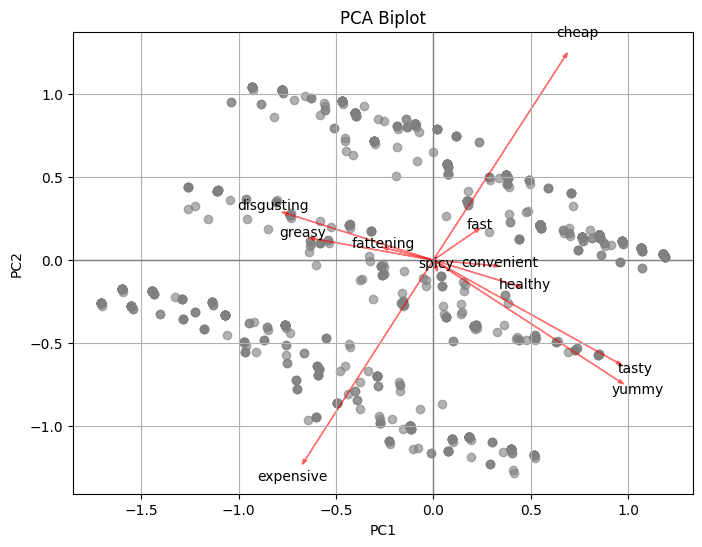

In [6]:
# PCA
pca = PCA()
pca_scores = pca.fit_transform(mcdonalds_binary)

# Plot PCA scores (PC1 vs PC2)
plt.figure(figsize=(8,6))
plt.scatter(pca_scores[:, 0], pca_scores[:, 1], color='grey', alpha=0.6)


# Add arrows for variable loadings
for i, var in enumerate(mcdonalds_binary.columns):
    plt.arrow(0, 0, pca.components_[0, i]*2, pca.components_[1, i]*2,
              color='red', alpha=0.5, head_width=0.02)
    plt.text(pca.components_[0, i]*2.2, pca.components_[1, i]*2.2,
             var, color='black', ha='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot')
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()



Above plot showing both the spread of observations in PCA space and the
influence of each original variable.
Each arrow shows how much a variable (like “yummy” or “greasy”) contributes to PC1 and PC2 — a biplot-style enhancement.
Useful for interpreting how each original feature influences the distribution of points in the PCA plot.




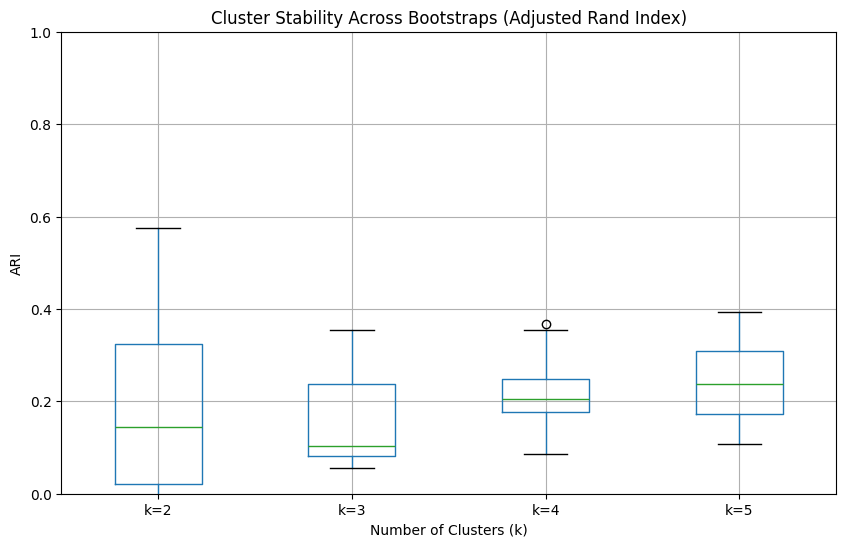

In [7]:
# Simulate binary data ( McDonald's dataset with "Yes"/"No" as 1/0)

np.random.seed(1234)
n_samples = 200
n_features = 11
data = np.random.binomial(1, p=0.5, size=(n_samples, n_features))
MD_binary = pd.DataFrame(data, columns=[f'Attr{i+1}' for i in range(n_features)])

# Function to compute ARI for different cluster sizes using fewer bootstraps
def bootstrap_cluster_stability(data, cluster_range, n_boot=20, n_init=5):
    stability_scores = {k: [] for k in cluster_range}

    for k in cluster_range:
        kmeans_orig = KMeans(n_clusters=k, n_init=n_init, random_state=42).fit(data)
        orig_labels = kmeans_orig.labels_

        for _ in range(n_boot):
            sample = resample(data, replace=True)
            kmeans_boot = KMeans(n_clusters=k, n_init=n_init, random_state=42).fit(sample)
            boot_labels = kmeans_boot.predict(data)  # Predict on original data
            ari = adjusted_rand_score(orig_labels, boot_labels)
            stability_scores[k].append(ari)

    return stability_scores

# Run stability check for k = 2 to 5
cluster_range = range(2, 6)
stability_results = bootstrap_cluster_stability(MD_binary, cluster_range)

# Convert to DataFrame for easy plotting
stability_df = pd.DataFrame(dict([(f'k={k}', pd.Series(v)) for k, v in stability_results.items()]))

# Plot boxplot of ARI values
plt.figure(figsize=(10, 6))
stability_df.boxplot()
plt.title("Cluster Stability Across Bootstraps (Adjusted Rand Index)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("ARI")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


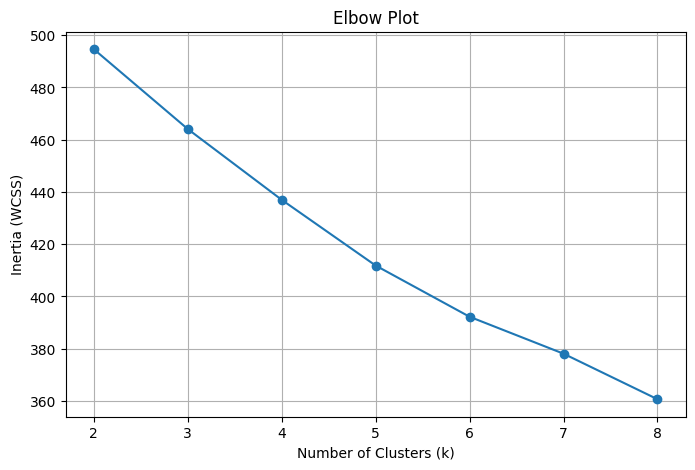

In [8]:
# Simulate binary data
np.random.seed(1234)
data = np.random.binomial(1, p=0.5, size=(200, 11))
MD_binary = pd.DataFrame(data, columns=[f'Attr{i+1}' for i in range(11)])

# Inertia (within-cluster sum of squares) for each k
inertias = []
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(MD_binary)
    inertias.append(kmeans.inertia_)

# Plot elbow curve, this help choose the best number of segments.
plt.figure(figsize=(8,5))
plt.plot(range(2, 9), inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Plot")
plt.grid(True)
plt.show()


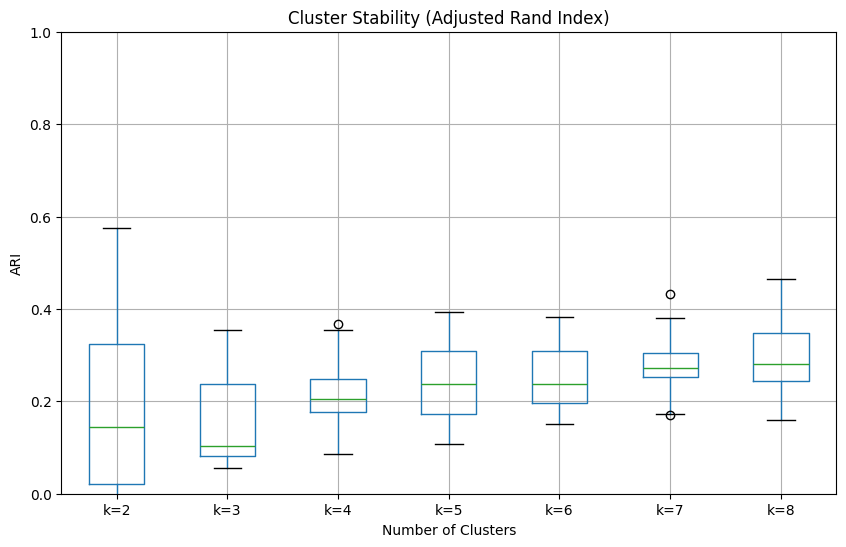

In [9]:
""" Creates bootstrapped datasets.For each bootstrap, performs clustering and compares with original clustering using adjusted Rand index (ARI).
The plot shows how stable the clusters are for each value of k. More stable clusters have higher and tighter ARI values. """


# Function to compute bootstrap ARI scores
def bootstrap_cluster_stability(data, cluster_range, n_boot=20, n_init=5):
    stability_scores = {k: [] for k in cluster_range}

    for k in cluster_range:
        kmeans_original = KMeans(n_clusters=k, n_init=n_init, random_state=42).fit(data)
        original_labels = kmeans_original.labels_

        for _ in range(n_boot):
            sample = resample(data, replace=True)
            kmeans_boot = KMeans(n_clusters=k, n_init=n_init, random_state=42).fit(sample)
            boot_labels = kmeans_boot.predict(data)
            ari = adjusted_rand_score(original_labels, boot_labels)
            stability_scores[k].append(ari)

    return stability_scores

# Compute for k = 2 to 8
stability = bootstrap_cluster_stability(MD_binary, range(2, 9), n_boot=20)

# Plot as boxplot
stability_df = pd.DataFrame({f'k={k}': pd.Series(v) for k, v in stability.items()})
stability_df.boxplot(figsize=(10, 6))
plt.title("Cluster Stability (Adjusted Rand Index)")
plt.xlabel("Number of Clusters")
plt.ylabel("ARI")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


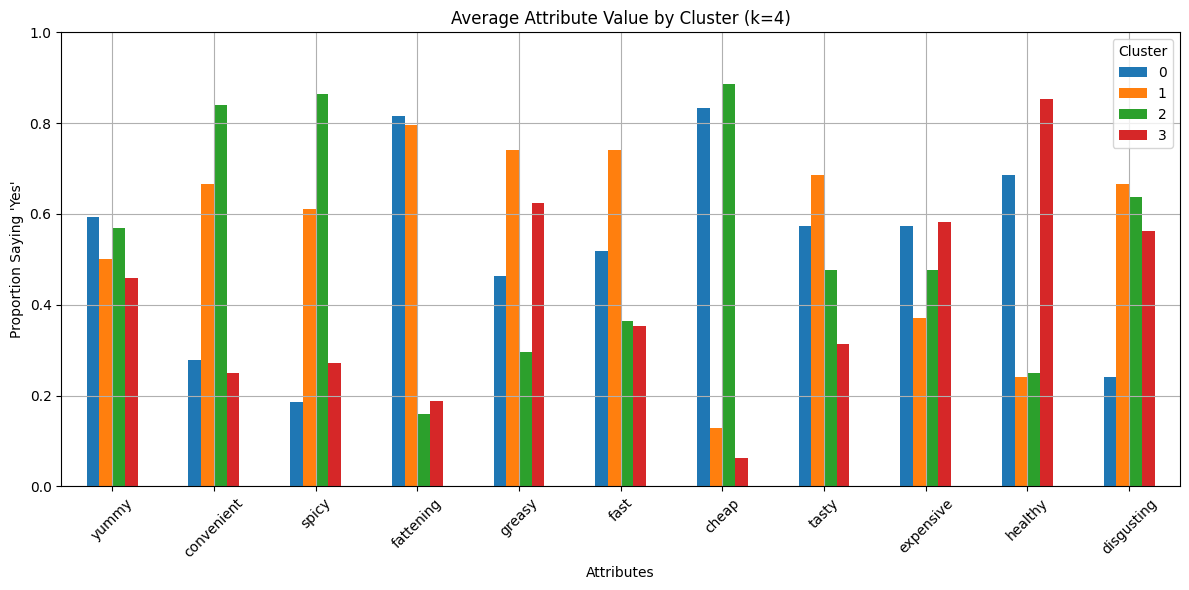

In [10]:
# Setting proper column names before clustering otherwise pandas set the default attribute name as Attr1, Attr2 and so on.
MD_binary.columns = [
    "yummy", "convenient", "spicy", "fattening", "greasy",
    "fast", "cheap", "tasty", "expensive", "healthy", "disgusting"
]


# Fit k=4 model
k4_model = KMeans(n_clusters=4, n_init=10, random_state=42)
clusters = k4_model.fit_predict(MD_binary)

# Add cluster label to data
MD_labeled = MD_binary.copy()
MD_labeled['Cluster'] = clusters

# Calculate average response for each attribute by cluster
cluster_profiles = MD_labeled.groupby('Cluster').mean().T

# Plot histograms of Attributes by Cluster (for k=4)
cluster_profiles.plot(kind='bar', figsize=(12, 6))
plt.title("Average Attribute Value by Cluster (k=4)")
plt.ylabel("Proportion Saying 'Yes'")
plt.xlabel("Attributes")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


**Using Mixtures of Regression Models**

Below is a implementation of a mixture of linear regression models using Expectation-Maximization (EM):

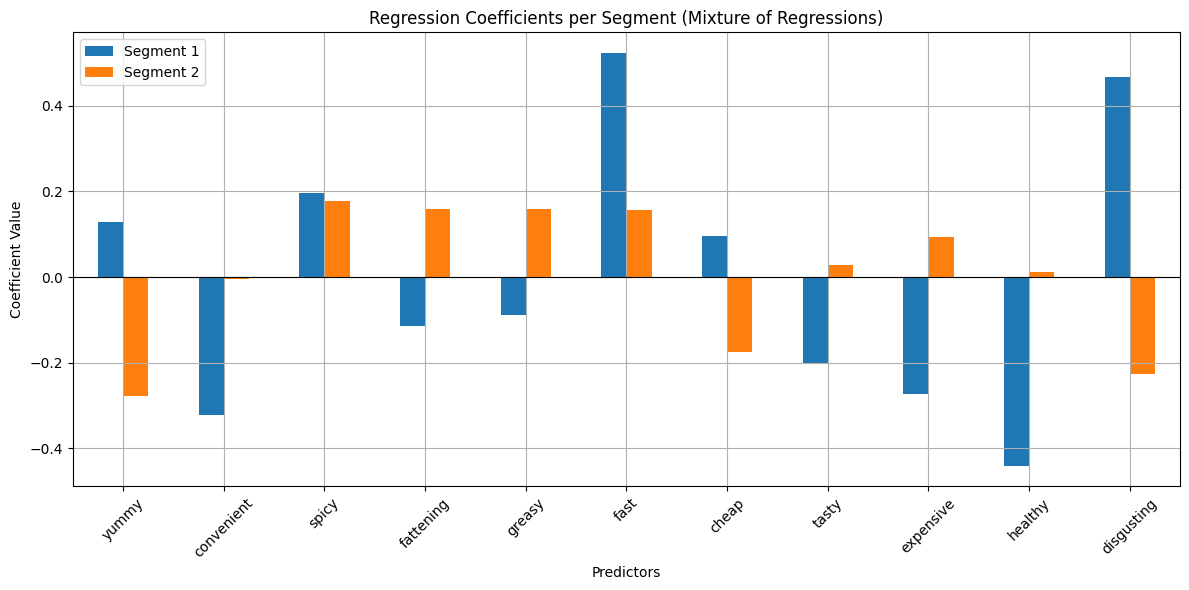

In [14]:
# Simulate 'mcdonalds' data (binary predictors + like scale)
np.random.seed(1234)
n = 1453
X = np.random.binomial(1, 0.5, size=(n, 11))
columns = ["yummy", "convenient", "spicy", "fattening", "greasy",
           "fast", "cheap", "tasty", "expensive", "healthy", "disgusting"]
mcd = pd.DataFrame(X, columns=columns)

# Simulate Likert scale and reverse it
like_raw = np.random.choice(range(-5, 6), size=n, p=[.1,.05,.05,.04,.04,.1,.1,.13,.16,.11,.12])
mcd['Like'] = like_raw
mcd['Like.n'] = 6 - mcd['Like']

# Define predictors and target
X = mcd[columns].values
y = mcd['Like.n'].values.reshape(-1, 1)

# Step 1: Fit GMM to segment data into 2 groups
gmm = GaussianMixture(n_components=2, random_state=1234)
segments = gmm.fit_predict(X)

# Step 2: Fit regression model in each segment
coefs = []
p_values = []  # Placeholder if  later want to do statsmodels per segment

for i in range(2):
    idx = np.where(segments == i)[0]
    reg = LinearRegression()
    reg.fit(X[idx], y[idx])
    coefs.append(reg.coef_[0])


# Convert to DataFrame
coef_df = pd.DataFrame(coefs, columns=columns, index=[f'Segment {i+1}' for i in range(2)])

# Step 3: Plot the coefficients
coef_df.T.plot(kind='bar', figsize=(12, 6))
plt.axhline(0, color='black', lw=0.8)
plt.title("Regression Coefficients per Segment (Mixture of Regressions)")
plt.ylabel("Coefficient Value")
plt.xlabel("Predictors")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


**Profiling Segments**

Now we need to understand what the four-segment k-means solution
means. The first step in this direction is to create a segment profile plot.

*  The first step in this direction is to create a segment profile plot. The segment
profile plot makes it easy to see key characteristics of each market segment.We achieve this by
calculating a hierarchical cluster analysis.
* Another visualisation that can help grasp the essence of market
segments is the segment separation plot.


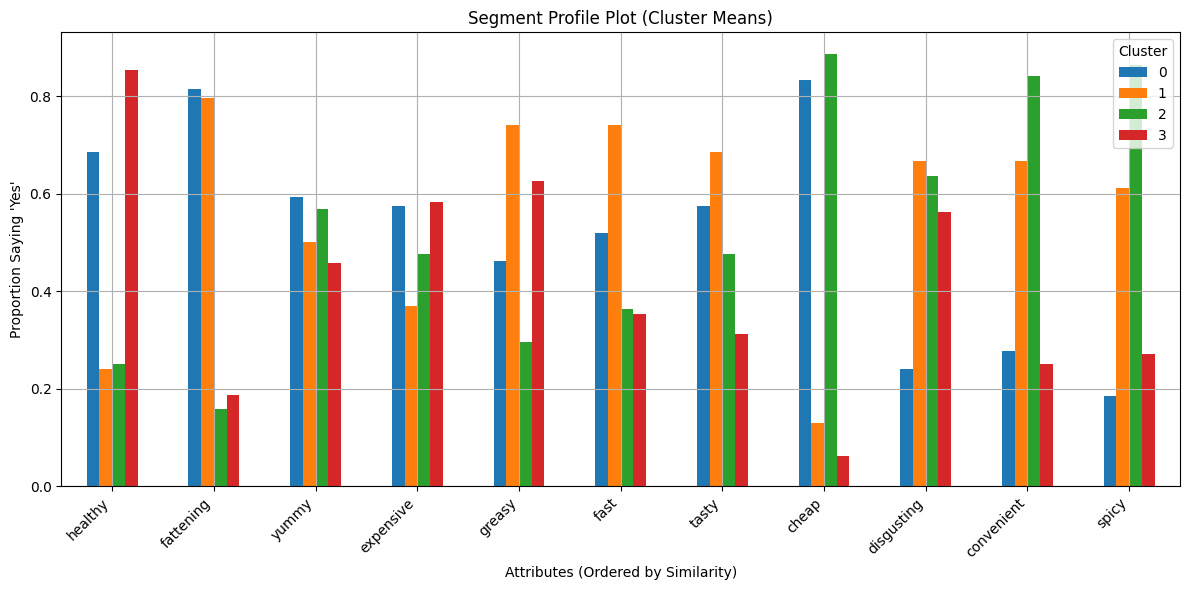

In [15]:
#Profiling Segments

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler

# Set proper column names before any clustering
MD_binary.columns = [
    "yummy", "convenient", "spicy", "fattening", "greasy",
    "fast", "cheap", "tasty", "expensive", "healthy", "disgusting"
]


# Get cluster labels
cluster_labels = kmeans.labels_

# Step 1: Compute cluster-wise means (profiling)
profile_df = MD_binary.copy()
profile_df['Cluster'] = cluster_labels
cluster_means = profile_df.groupby('Cluster').mean()

# Step 2: Reorder variables using hierarchical clustering on transposed data
link = linkage(cluster_means.T, method='ward')
dendro = dendrogram(link, no_plot=True)
ordered_columns = [cluster_means.columns[i] for i in dendro['leaves']]

# Step 3: Plot segment profile with actual attribute names
cluster_means[ordered_columns].T.plot(kind='bar', figsize=(12, 6))
plt.title("Segment Profile Plot (Cluster Means)")
plt.ylabel("Proportion Saying 'Yes'")
plt.xlabel("Attributes (Ordered by Similarity)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()


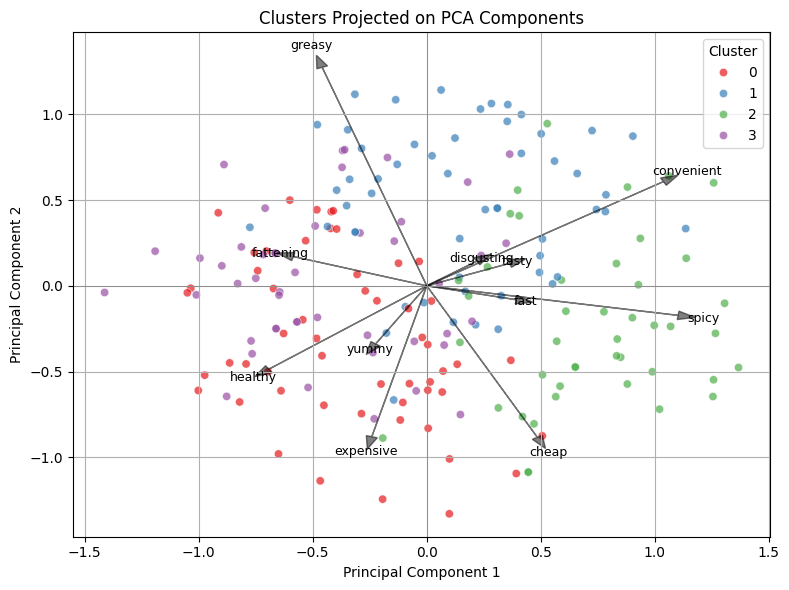

In [16]:
#Segment separation plot.

# Step 1: PCA on binary data
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(MD_binary)

# Step 2: Scatter plot of individuals, colored by cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_proj[:, 0], y=pca_proj[:, 1],
                hue=cluster_labels, palette='Set1', alpha=0.7)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Clusters Projected on PCA Components")
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.grid(True)

# Step 3: Add variable arrows
for i, col in enumerate(MD_binary.columns):
    plt.arrow(0, 0,
              pca.components_[0, i]*2,
              pca.components_[1, i]*2,
              color='black', alpha=0.5, head_width=0.05)
    plt.text(pca.components_[0, i]*2.2,
             pca.components_[1, i]*2.2,
             col, ha='center', va='center', fontsize=9)

plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


**Describing Segments**

Using a simple mosaic plot, we can visualise the association between segment
membership and loving or hating McDonald’s.To do this,we first extract the

*   We first extract the segment membership for each consumer for the four-segment solution.
*  Next we cross-tabulate segment membership and the love-hate variable.

 Finally, we generate the mosaic plot with cells colours indicating the deviation of the observed frequencies in each cell from the expected frequency if variables are not associated.

<Figure size 1500x1000 with 0 Axes>

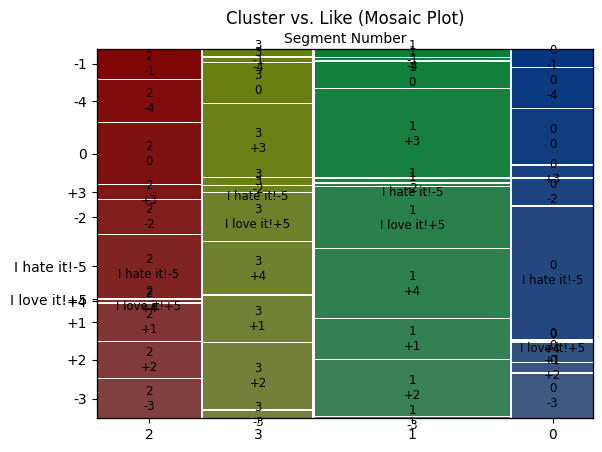

<Figure size 1000x600 with 0 Axes>

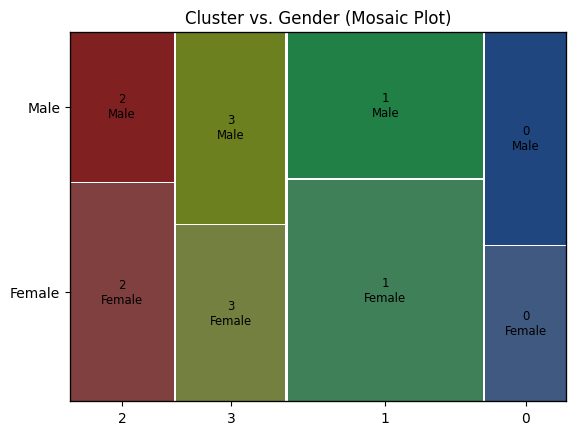

In [22]:
#Describing Segments

from statsmodels.graphics.mosaicplot import mosaic

#Perform clustering on binary subset
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
cluster_labels_mcdonalds = kmeans.fit_predict(mcdonalds_binary)

# Add cluster labels to the full dataframe
mcdonalds['Cluster'] = cluster_labels_mcdonalds

# Simulate a Like column with values from -5 to +5
#mcdonalds['Like'] = np.random.choice(range(-5, 6), size=len(mcdonalds))

contingency_like = pd.crosstab(mcdonalds['Cluster'], mcdonalds['Like'])

# Mosaic plot for Cluster vs. Like
plt.figure(figsize=(15, 10))
mosaic(mcdonalds, ['Cluster', 'Like'])
plt.title("Cluster vs. Like (Mosaic Plot)")
plt.xlabel("Segment Number")
plt.show()

# Mosaic plot for Cluster vs. Gender
plt.figure(figsize=(10, 6))
mosaic(mcdonalds, ['Cluster', 'Gender'])
plt.title("Cluster vs. Gender (Mosaic Plot)")
plt.show()


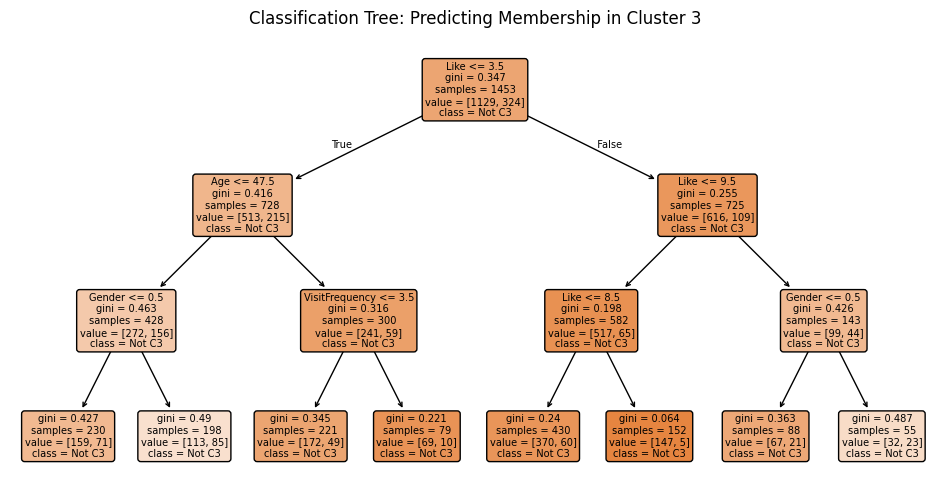

In [18]:
# The resulting classification tree shown below, the independent variables used in the tree are LIKE, AGE and VISITFREQUENCY.
# GENDER is not used to split the respondents into groups.

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Convert to binary target: is cluster 3?
mcdonalds['Is_Cluster3'] = (mcdonalds['Cluster'] == 3).astype(int)

# Encode categorical variables
features = ['Like', 'Age', 'VisitFrequency', 'Gender']
X = mcdonalds[features].copy()
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col])

y = mcdonalds['Is_Cluster3']

# Fit classification tree
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X, y)

# Plot the tree
plt.figure(figsize=(12, 6))
plot_tree(tree_model, feature_names=features, class_names=["Not C3", "C3"],
          filled=True, rounded=True)
plt.title("Classification Tree: Predicting Membership in Cluster 3")
plt.show()


**Selecting the Target Segments**

The segment evaluation plot is extremely simplified because only
a small number of descriptor variables are available for the fast food data set.

*   The frequency of visiting McDonald’s is plotted along the x-axis.
*   The extent of liking or hating McDonald’s is plotted along the y-axis.
*   The bubble size
represents the percentage of female consumers.







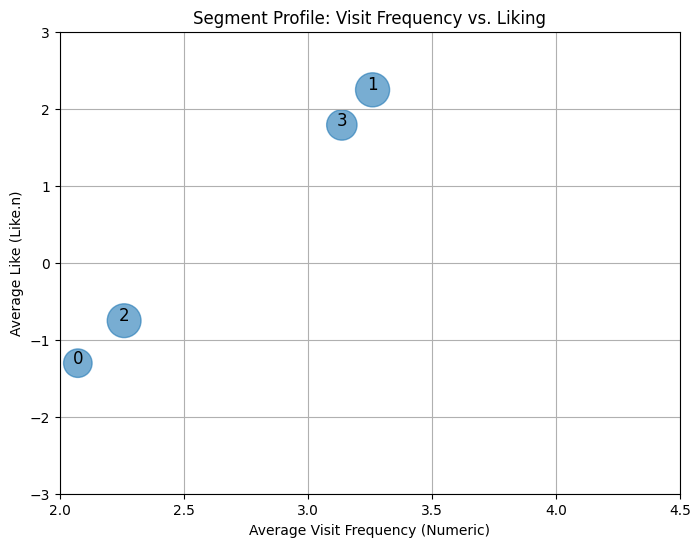

In [19]:
# Convert VisitFrequency to numeric scale define a mapping:

visit_mapping = {
    "Every day": 5,
    "Once a week": 4,
    "Every three months": 3,
    "Once a year": 2,
    "Never": 1
}
mcdonalds['VisitFreqNum'] = mcdonalds['VisitFrequency'].map(visit_mapping)

like_mapping = {
    "I hate it!": -5, "-4": -4, "-3": -3, "-2": -2, "-1": -1, "0": 0,
    "+1": 1, "+2": 2, "+3": 3, "+4": 4, "I love it!": 5
}

mcdonalds['Like.n'] = mcdonalds['Like'].map(like_mapping)

# Compute segment-wise averages
visit_avg = mcdonalds.groupby('Cluster')['VisitFreqNum'].mean()
like_avg = mcdonalds.groupby('Cluster')['Like.n'].mean()
female_prop = (mcdonalds['Gender'] == 'Female').groupby(mcdonalds['Cluster']).mean()

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(visit_avg, like_avg, s=female_prop * 1000, alpha=0.6)

for i in range(len(visit_avg)):
    plt.text(visit_avg.iloc[i], like_avg.iloc[i], str(visit_avg.index[i]), fontsize=12, ha='center')

plt.xlabel("Average Visit Frequency (Numeric)")
plt.ylabel("Average Like (Like.n)")
plt.xlim(2, 4.5)
plt.ylim(-3, 3)
plt.title("Segment Profile: Visit Frequency vs. Liking")
plt.grid(True)
plt.show()